In [34]:
from come import eod_api as eod
from come import portfolio_analysis as pa
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time as tm
from array import array
import matplotlib.dates as mdates
import statsmodels.api as sm
import itertools as it

In [5]:

def numpy_gerber_statistic(df1, df2, threshold, returns=False):
    """ Function for estimating the Gerber Statistic of co-movement between two time series.
    source : file:///C:/Users/Come5/Downloads/SSRN-id3880054.pdf

    Args:
        df1 (pd.DataFrame): time series of prices or returns.
        df2 (pd.DataFrame): time series of prices or returns.
        threshold (float): threshold parameter for seperating scatter regions of co-movements.
        returns (bool, defaults to False): if True, time series are prices returns. Defaults to False (prices).

    Returns:
        float: Gerber Statistic as robust co-movement measure for covariance matrix estimation.
    """

    # False means that we work with prices

    if returns == False: # So we need to calculte returns
        returns1 = df1[1:] / df1[0:-1] - 1.
        returns2 = df2[1:] / df2[0:-1] - 1.

    else:
        returns1 = df1
        returns2 = df2

    # Returns are centered to be compared to threshold
    centered1 = returns1[1:] / np.std(returns1[1:])
    centered2 = returns2[1:] / np.std(returns2[1:])

    uu = dd = ud = du = nn = 0.

    for i in range(len(centered1)):
        if (centered1[i] >= threshold) & (centered2[i] >= threshold):
            uu += 1
        elif (-threshold <= centered1[i] <= threshold) & (-threshold <= centered2[i] <= threshold):
            nn += 1
        elif (centered1[i] <= -threshold) & (centered2[i] <= -threshold):
            dd += 1
        elif (centered1[i] >= threshold) & (centered2[i] <= -threshold):
            ud += 1
        elif (centered1[i] <= -threshold) & (centered2[i] >= threshold):
            du += 1
        else:
            next

    numerator = uu + dd - ud - du
    denominator = len(centered1) - nn

    return numerator / denominator


In [6]:
def numpy_gerber_covariance_matrix(df, threshold, returns=False):
    """Function to estimate the covariance matrix of multiple time series, through prices or returns,
    based on the gerber statistic, which is a robust co-movement statistic.
    source : https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3880054

    Args:
        df (pd.DataFrame): DataFrame of time series (prices or returns).
        threshold (float): threshold parameter for seperating scatter regions of co-movements.
        returns (bool, optional): if True, time series are prices returns. Defaults to False (prices).

    Returns:
        np.ndarray: covariance matrix
    """
    new_df = df.copy()

    # False means that we work with prices
    if returns == False: # So we need to calculte returns
        new_df = new_df.pct_change().fillna(0)

    flatten_matrix = []
    for i in range(new_df.shape[1]):
        for j in range(new_df.shape[1]):
            flatten_matrix.append(numpy_gerber_statistic(new_df.iloc[0:,i].to_numpy(), new_df.iloc[0:,j].to_numpy(), threshold, True))

    reshaped_matrix = np.asarray(flatten_matrix).reshape(new_df.shape[1], new_df.shape[1])
    return reshaped_matrix

In [7]:
YEARLY_DAYS = 250
FIG_SIZE = (12,6)
tok=os.environ["EOD_TOKEN"]

In [8]:
def create_dataset(token:str, tickers:list, start_dt:str, end_dt:str) -> pd.DataFrame:
    """Function to extract and calculate dayly returns for a list of eod tickers.

    Args:
        token (String): token to access the eod database.
        tickers (List): list of tickers.
        start_dt (String) : start date given formatted like YYYY-MM-DD.
        end_dt (String) : end date given formatted like YYYY-MM-DD.

    Returns:
        pd.DataFrame: DataFrame of daily returns
    """
    all_prices = eod.adjusted_prices(token, tickers)
    all_returns = all_prices.pct_change().dropna()
    return all_returns[(all_returns.index >= start_dt) & (all_returns.index <= end_dt)]

In [9]:
my_data = create_dataset(tok, ["GSPC.INDX","BTC-USD.CC","GC.COMM"], "2014-08-01","2023-08-01")
my_data

3/3 extracted


,GSPC.INDX,BTC-USD.CC,GC.COMM
date,,,
2014-08-01,-0.002859,0.014808,0.010536
2014-08-04,0.007189,-0.010311,-0.004557
2014-08-05,-0.009685,-0.005683,-0.002793
2014-08-06,0.000016,-0.001337,0.017817
2014-08-07,-0.005557,0.007211,0.003287
...,...,...,...
2023-07-26,-0.000155,0.004365,0.003259
2023-07-27,-0.006425,-0.004915,-0.012385
2023-07-28,0.009878,0.003716,0.007555


<h2>Corrélation de Pearson<h2>

In [10]:
my_data.columns = ["GSPC","BTC","GOLD"]
my_data.corr()

,GSPC,BTC,GOLD
GSPC,1.000000,0.204914,0.017201
BTC,0.204914,1.000000,0.086260
GOLD,0.017201,0.086260,1.000000


<h2>Corrélation de Spearman<h2>

In [38]:
my_data.corr('spearman')




,GSPC,BTC,GOLD
GSPC,1.000000,0.152976,-0.038574
BTC,0.152976,1.000000,0.082901
GOLD,-0.038574,0.082901,1.000000


<h2>statistiques descriptives<h2>

In [37]:
pd.DataFrame(my_data.std()*np.sqrt(252),columns=["Volatility"])


,Volatility
GSPC,0.183118
BTC,0.709202
GOLD,0.148713


In [11]:
def dataframe_of_rolling_correlations(df, annual_factor, threshold = None):
    """Function to calculate the rolling correlation for each combinaison of tickers without repetition.
       The correlation is calculated with a given windows size through the annual_factor parameter.

    Args:
        df (pd.DataFrame): dataframe that contains daily returns for universe.
        annual_factor (int): annualization factor.
        threshold (Double): threshold parameter for seperating scatter regions of co-movements. 

    Returns:
        pd.DataFrame: dataframe that contains the rollings correlations for each combinaison of tickers.
    """
    combinaisons_sans_repet = list(it.combinations(df.columns, 2))
    results = dict()

    for combinaison in combinaisons_sans_repet:
        variable_name = combinaison[0] + "_vs_" + combinaison[1] 

        # We use loop for calculation, which is not the most efficient way to do it
        # but it ensure that we use the same range of data for the calculus.
        # Note also that the code structure could optimized, but we prioritize the ease of read
        if threshold == None: # if None, we apply Pearson's correlation
            correlation_ts = dict()
            for i in range(annual_factor + 1, df.shape[0]):
                correlation_ts.update({
                    df.index[i]:df[combinaison[0]].iloc[(i-annual_factor):i].corr(df[combinaison[1]].iloc[(i-annual_factor):i]), 
                })
            
            correlation_df = pd.Series(correlation_ts)
            
            results.update({
                variable_name:correlation_df
            })
        elif threshold == "spearman":
            correlation_ts = dict()
            for i in range(annual_factor + 1, df.shape[0]):
                correlation_ts.update({
                    df.index[i]:df[combinaison[0]].iloc[(i-annual_factor):i].corr(df[combinaison[1]].iloc[(i-annual_factor):i], method = "spearman"), 
                })
            
            correlation_df = pd.Series(correlation_ts)
            
            results.update({
                variable_name:correlation_df
            })
        else: # if we have a threshold, we apply Gerber's co-movement statistics
            correlation_ts = dict()
            for i in range(annual_factor + 1, df.shape[0]):
                correlation_ts.update({
                    df.index[i]:numpy_gerber_statistic(
                        df[combinaison[0]].iloc[(i-annual_factor):i], 
                        df[combinaison[1]].iloc[(i-annual_factor):i], 
                        threshold, returns=True)
                })
            
            correlation_df = pd.Series(correlation_ts)
            
            results.update({
                variable_name:correlation_df
            })
    return pd.DataFrame().from_dict(results, orient="index").T.dropna()

In [12]:
def dataframe_rolling_volatility(df:pd.DataFrame, annual_factor:float) -> pd.DataFrame:
    """Function to calculate the rolling volatility for a dataframe of return

    Note: 
        This piece of code works but is inefficiente. We have done that for the ease of read
        and also to be sure that the data are treated the same way (because rolling function of pandas can
        introduce some biais).

    Args:
        df (pd.DataFrame): dataframe of daily returns.
        annual_factor (float): windows length but also annualization factor

    Returns:
        pd.DataFrame: annualized volatility calculated on rolling window.
    """
    results = dict()

    for i in range(annual_factor + 1, df.shape[0]):
        results.update({
            df.index[i]:df.iloc[(i-annual_factor):i].std()*np.sqrt(annual_factor)
        })

    results_df = pd.DataFrame().from_dict(results, orient="index")
    results_df.columns = [str(df.name) + "_roll_vol"]
    return results_df

In [13]:
#roll_vol_gspc = my_data["GSPC"].rolling(YEARLY_DAYS).std()*np.sqrt(YEARLY_DAYS)
#roll_vol_gspc = roll_vol_gspc.dropna().to_frame()

roll_vol_gspc = dataframe_rolling_volatility(my_data["GSPC"], YEARLY_DAYS)
roll_vol_gspc

,GSPC_roll_vol
2015-07-31,0.121636
2015-08-03,0.121473
2015-08-04,0.121095
2015-08-05,0.121123
2015-08-06,0.121007
...,...
2023-07-26,0.188985
2023-07-27,0.187248
2023-07-28,0.187017
2023-07-31,0.186749


In [14]:
pearson_roll_corr = dataframe_of_rolling_correlations(my_data, YEARLY_DAYS)
spearman_roll_corr = dataframe_of_rolling_correlations(my_data, YEARLY_DAYS, "spearman")
gerber_roll_corr = dataframe_of_rolling_correlations(my_data, YEARLY_DAYS, 0.5)

<h2>Corrélation sur une fenêtre de 252 jours<h2>

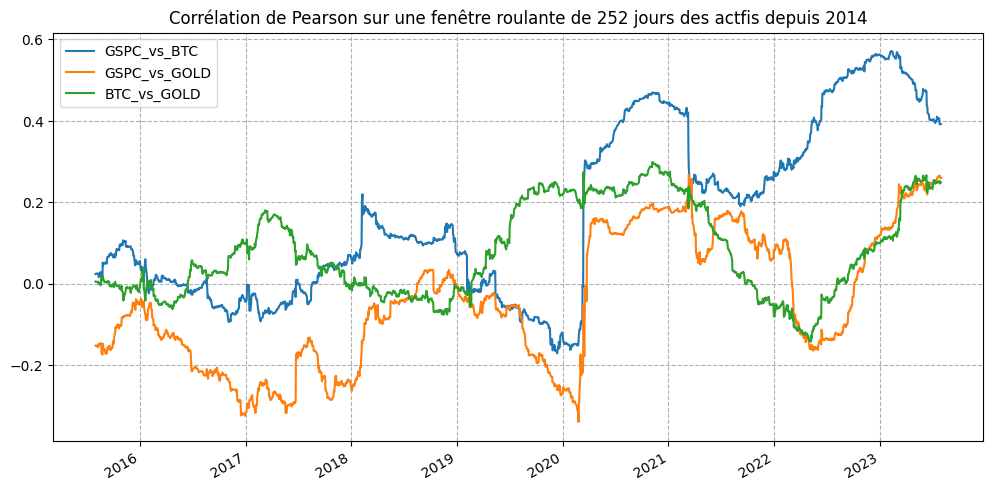

In [41]:
pearson_roll_corr.plot(figsize=FIG_SIZE)
plt.grid(linestyle="--")
plt.title("Corrélation de Pearson sur une fenêtre roulante de 252 jours des actfis depuis 2014")
plt.show()

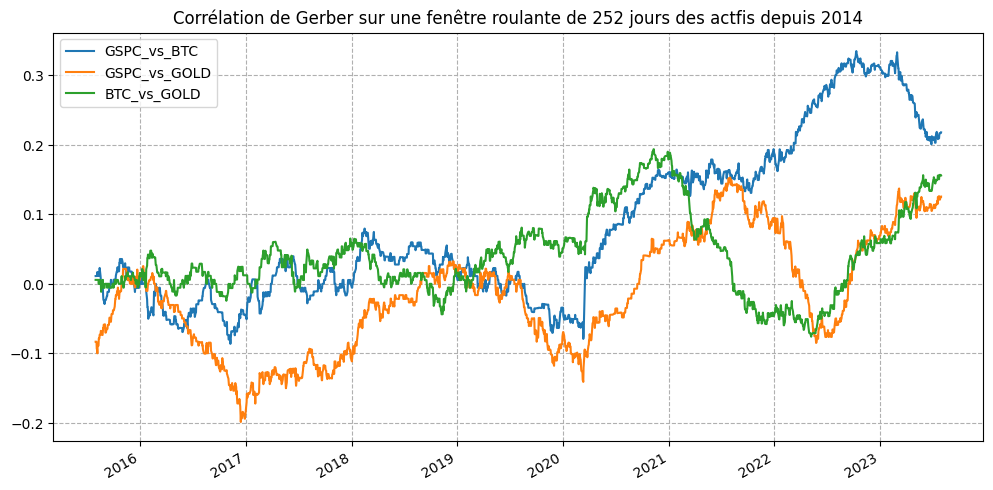

In [39]:
gerber_roll_corr.plot(figsize=FIG_SIZE)
plt.grid(linestyle="--")
plt.title("Corrélation de Gerber sur une fenêtre roulante de 252 jours des actfis depuis 2014")
plt.show()


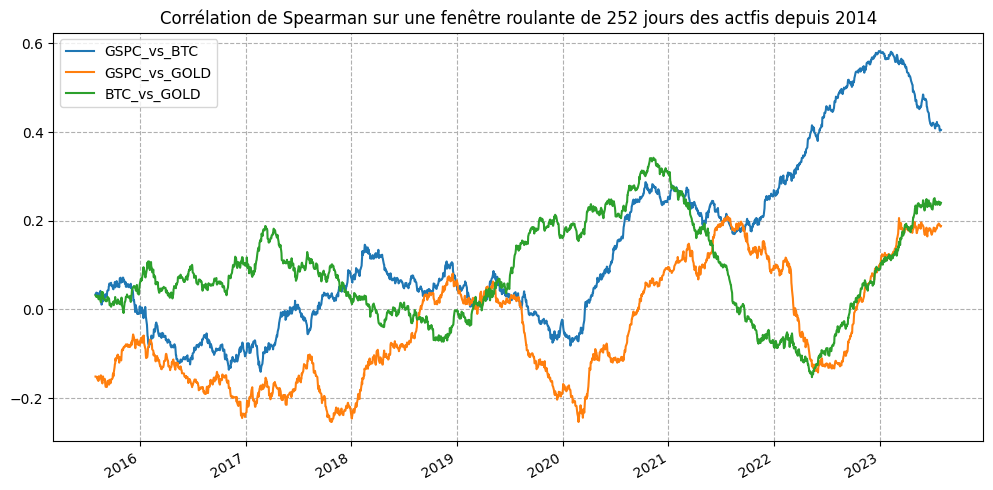

In [40]:
spearman_roll_corr.plot(figsize=FIG_SIZE)
plt.grid(linestyle="--")
plt.title("Corrélation de Spearman sur une fenêtre roulante de 252 jours des actfis depuis 2014")
plt.show()


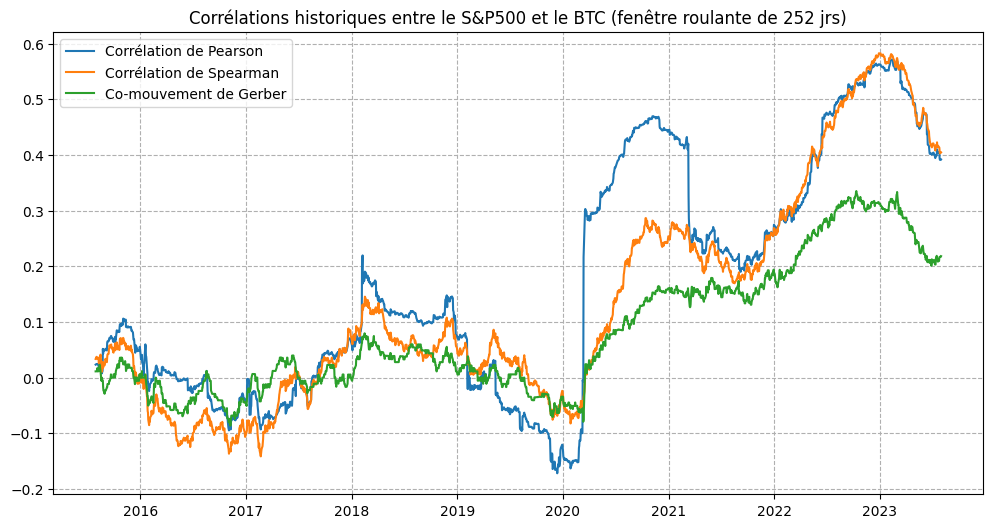

In [17]:
plt.plot(pearson_roll_corr["GSPC_vs_BTC"])
plt.plot(spearman_roll_corr["GSPC_vs_BTC"])
plt.plot(gerber_roll_corr["GSPC_vs_BTC"])
plt.title("Corrélations historiques entre le S&P500 et le BTC (fenêtre roulante de 252 jrs)")
plt.legend(["Corrélation de Pearson","Corrélation de Spearman","Co-mouvement de Gerber"])
plt.grid(linestyle="--")
plt.gcf().set_size_inches(FIG_SIZE) 
plt.show()


In [18]:
#GERBER
threshold = 0.5

combinaisons = list(it.combinations(my_data.columns, 2))

for combin in combinaisons:
    txt = f"Correlation (entre nos deux dates) pour {combin[0]} et {combin[1]} est de {numpy_gerber_statistic(my_data[combin[0]], my_data[combin[1]], 0.5, returns=True):.2%}"
    print(txt)

Correlation (entre nos deux dates) pour GSPC et BTC est de 8.20%
Correlation (entre nos deux dates) pour GSPC et GOLD est de -1.75%
Correlation (entre nos deux dates) pour BTC et GOLD est de 3.04%


In [19]:
gerber_corr_matrix = pd.DataFrame(numpy_gerber_covariance_matrix(my_data, 0.5, True), index = my_data.columns, columns = my_data.columns)

gerber_corr_matrix

,GSPC,BTC,GOLD
GSPC,1.000000,0.082031,-0.017456
BTC,0.082031,1.000000,0.030378
GOLD,-0.017456,0.030378,1.000000


In [20]:
centered_returns = my_data / my_data.std()
centered_returns

,GSPC,BTC,GOLD
date,,,
2014-08-01,-0.247857,0.331458,1.124693
2014-08-04,0.623221,-0.230791,-0.486407
2014-08-05,-0.839634,-0.127204,-0.298150
2014-08-06,0.001354,-0.029937,1.901875
2014-08-07,-0.481707,0.161411,0.350869
...,...,...,...
2023-07-26,-0.013476,0.097708,0.347901
2023-07-27,-0.556955,-0.110018,-1.322064
2023-07-28,0.856312,0.083185,0.806478


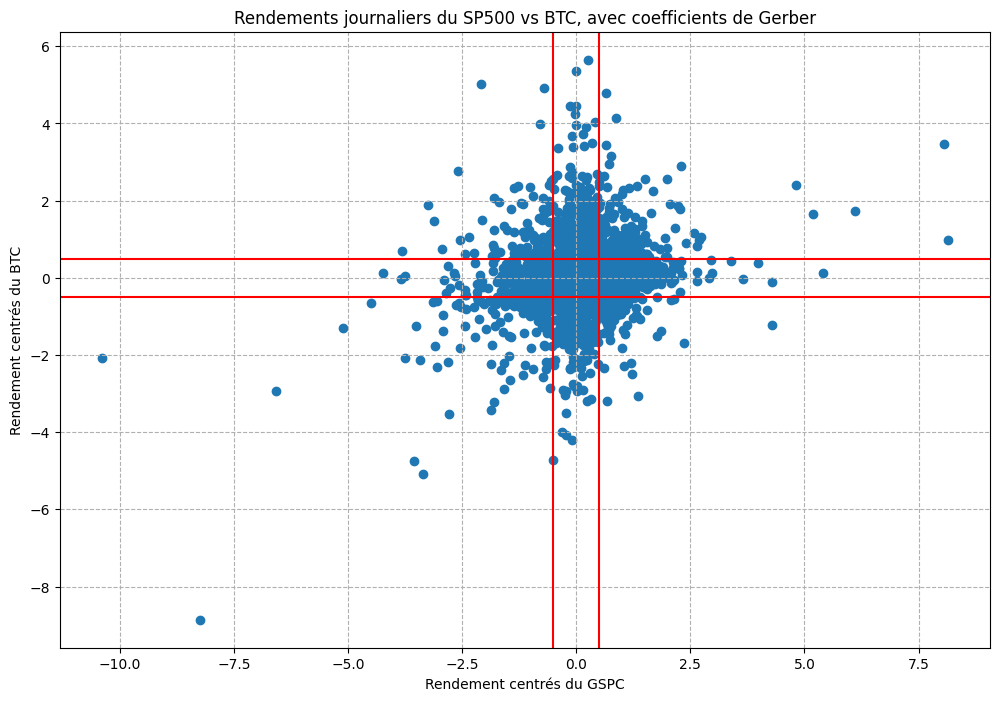

In [21]:
plt.scatter(centered_returns["GSPC"], centered_returns["BTC"])
plt.xlabel('Rendement centrés du GSPC')
plt.ylabel('Rendement centrés du BTC')
plt.title("Rendements journaliers du SP500 vs BTC, avec coefficients de Gerber")
plt.axvline(x = threshold, color = 'r', label = 'gc')
plt.axvline(x = threshold * -1, color = 'r', label = 'gc')
plt.axhline(y = threshold, color = 'r', label = 'gc')
plt.axhline(y = threshold * -1, color = 'r', label = 'gc')
plt.grid(linestyle="--")
plt.gcf().set_size_inches((12, 8)) 
plt.show()

La cellule ci-dessous, permet de calculer la variable var_roll_vol, qui est la volatilité de notre volatilité. C'est cette variable, qui nous permet de définir les zones de risque.

In [22]:
# volatilité de la volatilité
var_roll_vol = roll_vol_gspc.pct_change(30).shift(-15).dropna() 
var_roll_vol.name = "var_roll_vol"

s = var_roll_vol > 0.
s = pd.Series(s.values.reshape(-1))

crisis_zones = np.vstack([s[s & (s.shift(1, fill_value=False) == False)].index.values, 
           s[s & (s.shift(-1, fill_value=False) == False)].index.values]).T

<h2>Corrélation de Pearson hors/en période de stress<h2>

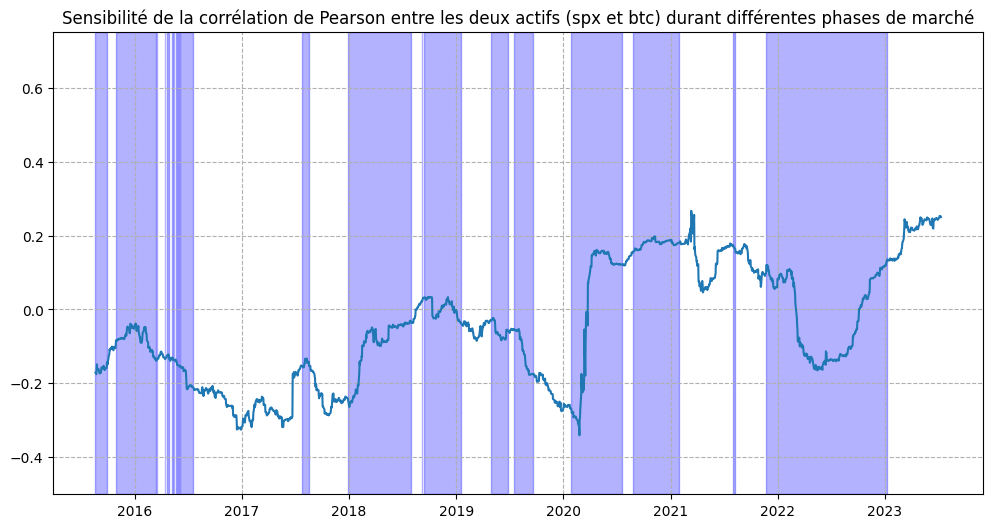

In [43]:
pearson_roll_corr_var_roll_vol =  pd.merge_asof(var_roll_vol, pearson_roll_corr, left_index=True, right_index=True, tolerance=pd.Timedelta('2 day'))
#print(pearson_roll_corr_var_roll_vol)

fig, ax = plt.subplots(figsize=FIG_SIZE)
ymin, ymax = [-0.5, 0.75]
ax.plot(pearson_roll_corr_var_roll_vol["GSPC_vs_GOLD"])
plt.ylim(ymin, ymax)

for arr_of_array in crisis_zones:
    ax.axvspan(var_roll_vol.index[arr_of_array[0]], var_roll_vol.index[arr_of_array[1]], color="blue", alpha=0.3)
plt.title("Sensibilité de la corrélation de Pearson entre les deux actifs (spx et btc) durant différentes phases de marché")
plt.grid(linestyle="--")
plt.show()

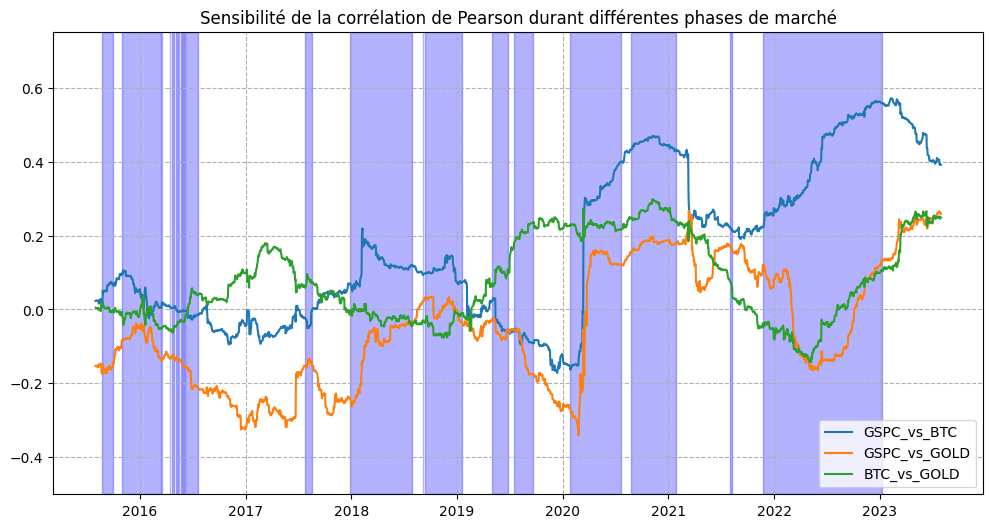

In [53]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
ymin, ymax = [-0.5, 0.75]
ax.plot(pearson_roll_corr)
plt.legend(pearson_roll_corr.columns)
plt.ylim(ymin, ymax)

for arr_of_array in crisis_zones:
    ax.axvspan(var_roll_vol.index[arr_of_array[0]], var_roll_vol.index[arr_of_array[1]], color="blue", alpha=0.3)
plt.title("Sensibilité de la corrélation de Pearson durant différentes phases de marché")
plt.grid(linestyle="--")
plt.show()

<h2>Corrélation de Gerber hors/en période de stress<h2> 

**Le graphique ci-dessus est à reproduire pour les autres combinaisons**
en changeant la ligne cette ligne suivante :
> ax.plot(pearson_roll_corr_var_roll_vol["GSPC_vs_GOLD"])

en changeant uniquement le nom de la colonne càd "GSPC_vs_GOLD"

Et supprimer cette cellule !!!

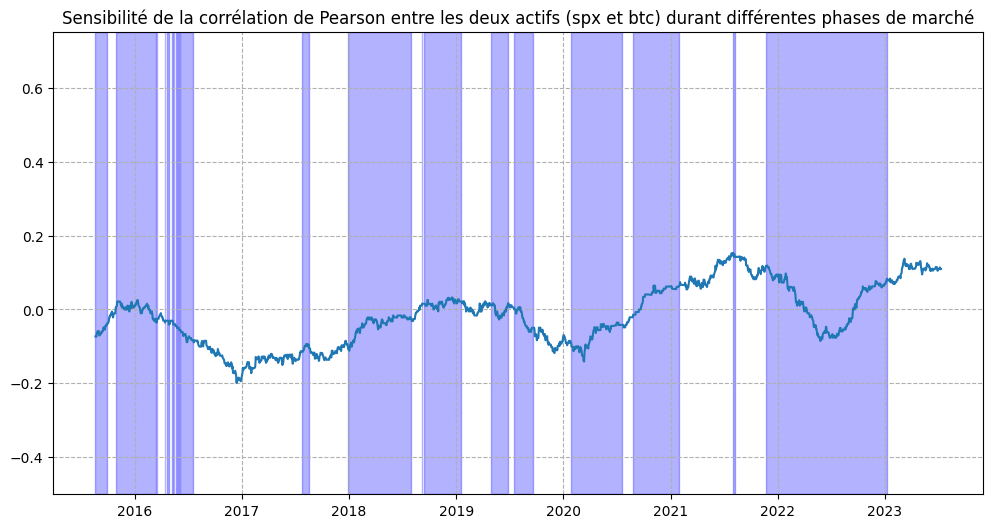

In [25]:
gerber_roll_corr_var_roll_vol =  pd.merge_asof(var_roll_vol, gerber_roll_corr, left_index=True, right_index=True, tolerance=pd.Timedelta('2 day'))
#print(pearson_roll_corr_var_roll_vol)

fig, ax = plt.subplots(figsize=FIG_SIZE)
ymin, ymax = [-0.5, 0.75]
ax.plot(gerber_roll_corr_var_roll_vol["GSPC_vs_GOLD"])
plt.ylim(ymin, ymax)

for arr_of_array in crisis_zones:
    ax.axvspan(var_roll_vol.index[arr_of_array[0]], var_roll_vol.index[arr_of_array[1]], color="blue", alpha=0.3)
plt.title("Sensibilité de la corrélation de Pearson entre les deux actifs (spx et btc) durant différentes phases de marché")
plt.grid(linestyle="--")
plt.show()

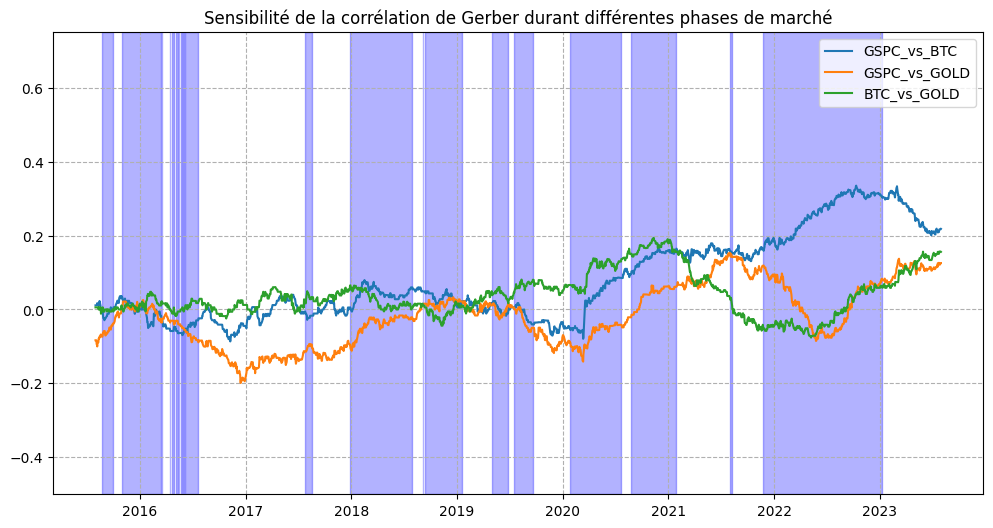

In [54]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
ymin, ymax = [-0.5, 0.75]
ax.plot(gerber_roll_corr)
plt.legend(gerber_roll_corr.columns)
plt.ylim(ymin, ymax)

for arr_of_array in crisis_zones:
    ax.axvspan(var_roll_vol.index[arr_of_array[0]], var_roll_vol.index[arr_of_array[1]], color="blue", alpha=0.3)
plt.title("Sensibilité de la corrélation de Gerber durant différentes phases de marché")
plt.grid(linestyle="--")
plt.show()

<h2>Corrélation de Spearman hors/en période de stress<h2> 

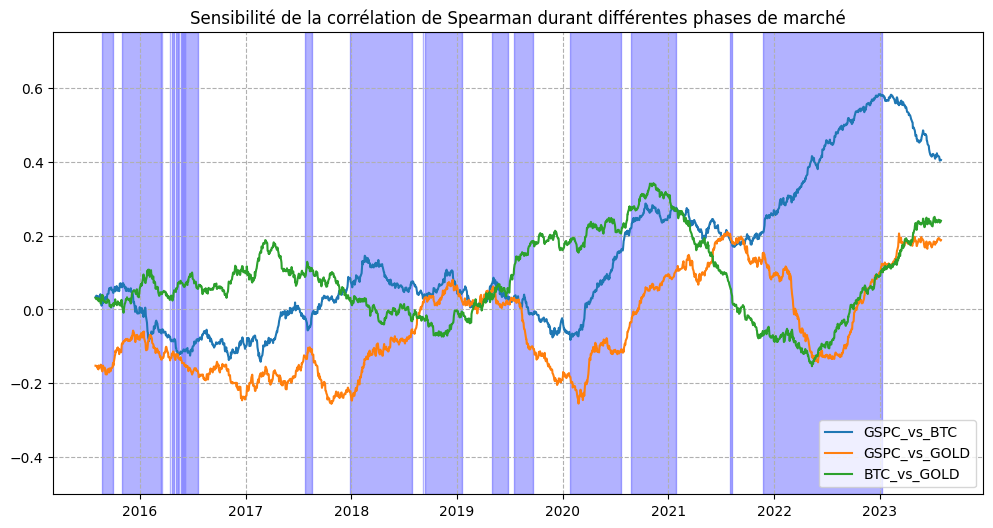

In [51]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
ymin, ymax = [-0.5, 0.75]
ax.plot(spearman_roll_corr)
plt.legend(spearman_roll_corr.columns)
plt.ylim(ymin, ymax)

for arr_of_array in crisis_zones:
    ax.axvspan(var_roll_vol.index[arr_of_array[0]], var_roll_vol.index[arr_of_array[1]], color="blue", alpha=0.3)
plt.title("Sensibilité de la corrélation de Spearman durant différentes phases de marché")
plt.grid(linestyle="--")
plt.show()

<h2>Regressions Linéaires</h2>

In [55]:
def linear_regression(endog_df, exo_df):
    """Linear regression between two dataframes in order to get alpha and beta parameters

    Args:
        endog_df (pd.DataFrame): dataframe of endogenous variable.
        exo_df (pd.DataFrame): dataframe of exogenous variable.

    Returns:
        Tuple: alpha and beta coefficients
    """
    exo_vol = sm.add_constant(exo_df)

    linear_model = sm.OLS(endog_df, exo_vol)
    lm_fit = linear_model.fit()
    print(lm_fit.summary())

    intervalle = (exo_df.max() - exo_df.min()) / exo_df.shape[0]

    simul_vol = np.arange(exo_df.min(), exo_df.max(), intervalle)
    modeled_corr = lm_fit.params[0] + lm_fit.params[1] * simul_vol
    regression_line = pd.DataFrame(modeled_corr, index=simul_vol)

    return lm_fit.params[0], lm_fit.params[1], regression_line

*Etude des modèles linéaires*

correlation (pearson) = alpha + beta * volatilité + erreurs

In [59]:
alpha_gspc_btc_pe, beta_gspc_btc_pe, regline_gspc_btc_pe = linear_regression(pearson_roll_corr["GSPC_vs_BTC"].values, roll_vol_gspc.values)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     1741.
Date:                Tue, 29 Aug 2023   Prob (F-statistic):          1.10e-274
Time:                        17:42:24   Log-Likelihood:                 919.16
No. Observations:                2014   AIC:                            -1834.
Df Residuals:                    2012   BIC:                            -1823.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1722      0.009    -19.530      0.0

In [60]:
alpha_gspc_gold_pe, beta_gspc_gold_pe, regline_gspc_gold_pe = linear_regression(pearson_roll_corr["GSPC_vs_GOLD"].values, roll_vol_gspc.values)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     1629.
Date:                Tue, 29 Aug 2023   Prob (F-statistic):          2.09e-261
Time:                        17:42:30   Log-Likelihood:                 1417.1
No. Observations:                2014   AIC:                            -2830.
Df Residuals:                    2012   BIC:                            -2819.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3004      0.007    -43.607      0.0

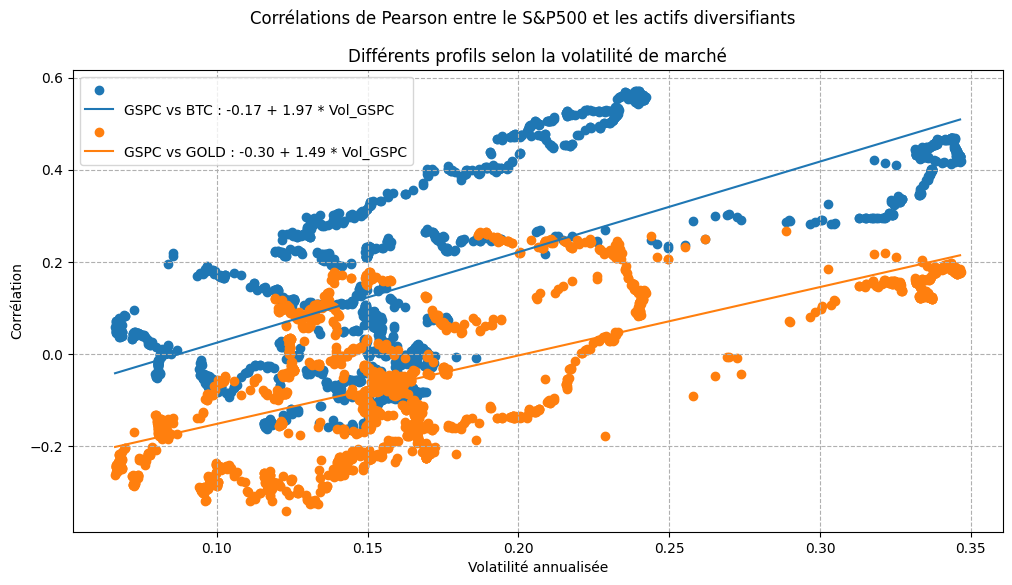

In [57]:
legend_names = ["",f"GSPC vs BTC : {alpha_gspc_btc_pe:.2f} + {beta_gspc_btc_pe:.2f} * Vol_GSPC","",f"GSPC vs GOLD : {alpha_gspc_gold_pe:.2f} + {beta_gspc_gold_pe:.2f} * Vol_GSPC"]

plt.scatter(roll_vol_gspc.values, pearson_roll_corr["GSPC_vs_BTC"].values)
plt.plot(regline_gspc_btc_pe)
plt.scatter(roll_vol_gspc.values, pearson_roll_corr["GSPC_vs_GOLD"].values)
plt.plot(regline_gspc_gold_pe)
plt.suptitle("Corrélations de Pearson entre le S&P500 et les actifs diversifiants")
plt.title("Différents profils selon la volatilité de marché")
plt.legend(legend_names)
plt.xlabel("Volatilité annualisée")
plt.ylabel("Corrélation")
plt.grid(linestyle="--")
plt.gcf().set_size_inches(FIG_SIZE) 
plt.show()

*Etude des modèles linéaires*

correlation (spearman) = alpha + beta * volatilité + erreurs

In [30]:
alpha_gspc_btc_sp, beta_gspc_btc_sp, regline_gspc_btc_sp = linear_regression(spearman_roll_corr["GSPC_vs_BTC"].values, roll_vol_gspc.values)
alpha_gspc_gold_sp, beta_gspc_gold_sp, regline_gspc_gold_sp = linear_regression(spearman_roll_corr["GSPC_vs_GOLD"].values, roll_vol_gspc.values)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     526.6
Date:                Tue, 29 Aug 2023   Prob (F-statistic):          1.06e-103
Time:                        09:16:56   Log-Likelihood:                 674.83
No. Observations:                2014   AIC:                            -1346.
Df Residuals:                    2012   BIC:                            -1334.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0772      0.010     -7.750      0.0

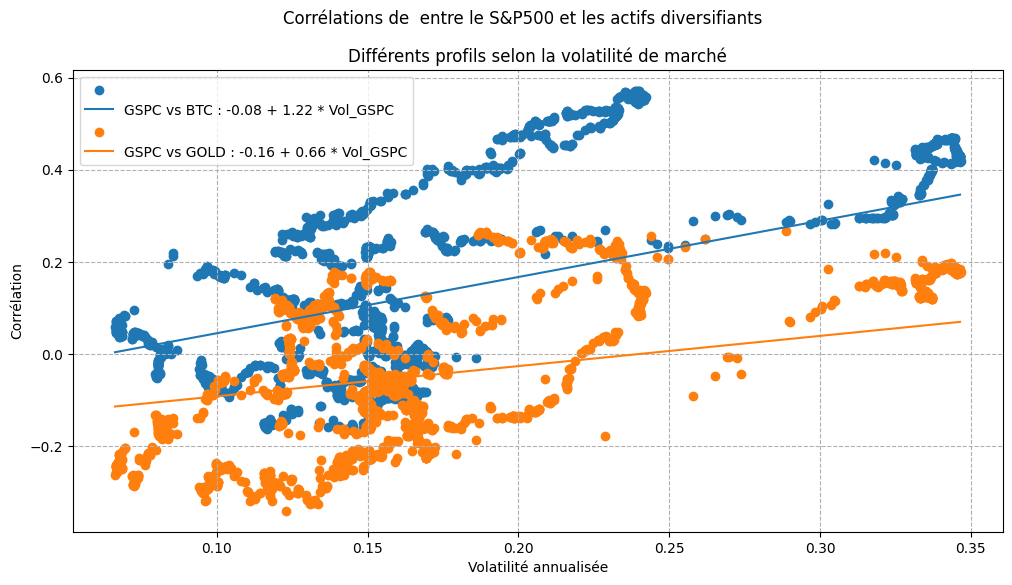

In [31]:
legend_names = ["",f"GSPC vs BTC : {alpha_gspc_btc_sp:.2f} + {beta_gspc_btc_sp:.2f} * Vol_GSPC","",f"GSPC vs GOLD : {alpha_gspc_gold_sp:.2f} + {beta_gspc_gold_sp:.2f} * Vol_GSPC"]

plt.scatter(roll_vol_gspc.values, pearson_roll_corr["GSPC_vs_BTC"].values)
plt.plot(regline_gspc_btc_sp)
plt.scatter(roll_vol_gspc.values, pearson_roll_corr["GSPC_vs_GOLD"].values)
plt.plot(regline_gspc_gold_sp)
plt.suptitle("Corrélations de  entre le S&P500 et les actifs diversifiants")
plt.title("Différents profils selon la volatilité de marché")
plt.legend(legend_names)
plt.xlabel("Volatilité annualisée")
plt.ylabel("Corrélation")
plt.grid(linestyle="--")
plt.gcf().set_size_inches(FIG_SIZE) 
plt.show()

*Etude des modèles linéaires*

correlation (gerber) = alpha + beta * volatilité + erreurs

In [32]:
alpha_gspc_btc_ge, beta_gspc_btc_ge, regline_gspc_btc_ge = linear_regression(gerber_roll_corr["GSPC_vs_BTC"].values, roll_vol_gspc.values)
alpha_gspc_gold_ge, beta_gspc_gold_ge, regline_gspc_gold_ge = linear_regression(gerber_roll_corr["GSPC_vs_GOLD"].values, roll_vol_gspc.values)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     437.2
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           5.13e-88
Time:                        09:16:56   Log-Likelihood:                 1721.7
No. Observations:                2014   AIC:                            -3439.
Df Residuals:                    2012   BIC:                            -3428.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0343      0.006     -5.786      0.0

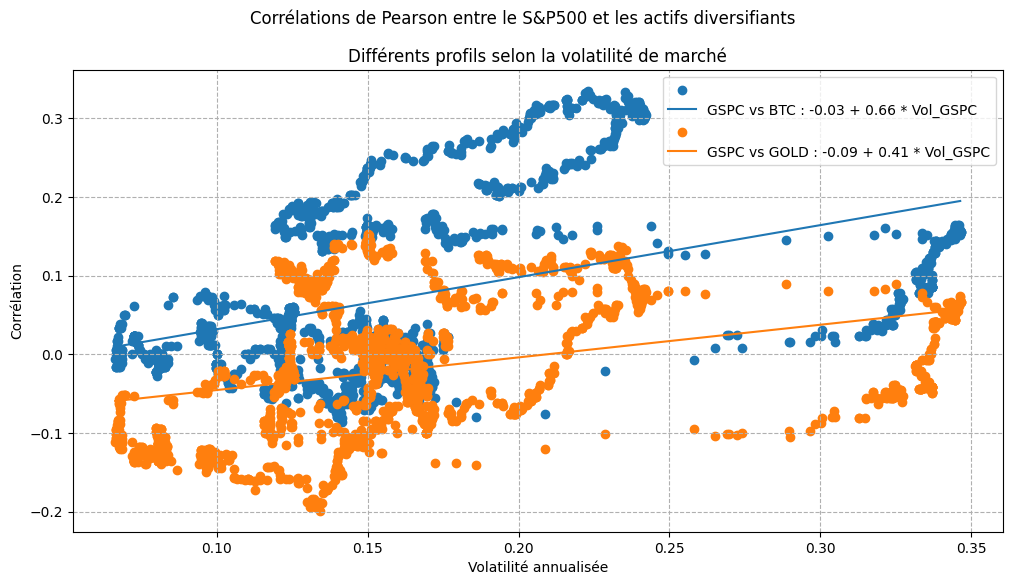

In [33]:
legend_names = ["",f"GSPC vs BTC : {alpha_gspc_btc_ge:.2f} + {beta_gspc_btc_ge:.2f} * Vol_GSPC","",f"GSPC vs GOLD : {alpha_gspc_gold_ge:.2f} + {beta_gspc_gold_ge:.2f} * Vol_GSPC"]

plt.scatter(roll_vol_gspc.values, gerber_roll_corr["GSPC_vs_BTC"].values)
plt.plot(regline_gspc_btc_ge)
plt.scatter(roll_vol_gspc.values, gerber_roll_corr["GSPC_vs_GOLD"].values)
plt.plot(regline_gspc_gold_ge)
plt.suptitle("Corrélations de Pearson entre le S&P500 et les actifs diversifiants")
plt.title("Différents profils selon la volatilité de marché")
plt.legend(legend_names)
plt.xlabel("Volatilité annualisée")
plt.ylabel("Corrélation")
plt.grid(linestyle="--")
plt.gcf().set_size_inches(FIG_SIZE) 
plt.show()

<h2>Conclusions</h2>

- Un actif est considéré comme diversifiant s'il permet de réduire le risque d'un portefeuille. La principale manière de mesurer le risque d'un portefeuille est de calculer sa volatilité. Cette volatilité est sensible à deux paramètres que sont les volatilités des actifs sous-jacents, et la covariance entre eux. Dans cette équation, le paramètre de corrélation (issue de la covariance) peut donc jouer un rôle de mitigeant.
- Il existe plusieurs méthodes pour estimer la corrélation entre plusieurs titres, et chaque méthode a ses avantages et ses inconvénients :
    - Corrélation de Pearson : permet d'obtenir une grandeur absolue (entre -1 et 1), mais est sensibles aux valeurs extrêmes ;
    - Corrélation de Spearman : mesure la corrélation sur les rangs. Cette méthode n'est pas sensible aux valeurs extrêmes, mais elle est aussi plus difficile à interpréter et à calculer et n'est pas sensible à la forme de la relation.
    - Statistique de Gerber : mesure de la force de la relation entre deux variables. Facile à calculer, peu sensible aux valeurs aberrantes, et elle est sensible à la forme de la relation.
- Nous avons conduit cette analyse en comparant les résultats issu des tests sur le Bitcoin et sur l'Or, l'Or étant considéré comme la valeur refuge en temps de crise et un actif particulièrement diversifiant dans un portefeuille.
- Que ce soit pour l'Or ou pour le BTC, toutes les méthodes nous ont permis d'observer une hausse de la corrélation lors des phases de stress sur les marchés (et plus particulièrement sur le S&P500). Cependant, les différentes modélisations donnent des résultats très différents.
- La statistique de Gerber est plus stable que celle de Spearman qui est plus stable que celle de Pearson.
- Les analyses ont également mise en lumière un changement structurel dans la corrélation entre le S&P500 et le BTC depuis la crise du Covid en 2020. Alors que oscillait autour de zéro entre 2014 et 2019, on observe depuis 2020 une corrélation moyenne bien plus importante (proche de 30% avec un pique proche des 60% lors de la baisse des marchés de 2022)
- Sa corrélation inférieur à 1 confère au BTC un certain pouvoir de diversification, mais qui semble disparaître à mesure que l'on avance dans le temps.
- Les résultats des regressions donnent également des informations intéressantes :
    - donner les principaux résultats des régressions